In [1]:
import torch
from torch_geometric.loader import DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import StepLR
from gnn import GNN
import os
from tqdm.auto import tqdm
import argparse
import time
import numpy as np
import random

Text(0.5, 0, '!!!Ariaaaal')

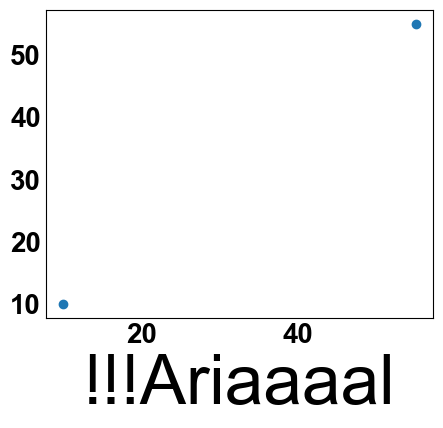

In [68]:
import matplotlib as mpl
from matplotlib import rc, rcParams
# check the font !!!!!!!!!!!!!!!!!!!!!
# switch to Arial
# if not working in Linux delet ~/.catch/matplotlib
plt.rcParams["font.family"] = "Arial"
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.fonttype'] = 42
mpl.font_manager.FontManager()

rc('font', weight='bold')
fig, ax = plt.subplots(figsize=(5, 4))
plt.scatter([10, 55], [10, 55])
ax.tick_params(axis='both', length=0, width=1.5, colors='black', grid_alpha=0, labelsize=20)
plt.xlabel('!!!Ariaaaal', fontname='Arial', fontsize=50)

In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
def train(model, device, loader, optimizer):
    model.train()
    loss_accum = 0

    for step, batch in enumerate(tqdm(loader, desc="Iteration")):
        batch = batch.to(device)

        pred = model(batch).view(-1,)
        optimizer.zero_grad()
        loss = reg_criterion(pred, batch.y)
        loss.backward()
        optimizer.step()

        loss_accum += loss.detach().cpu().item()

    return loss_accum / (step + 1)

In [4]:
def eval(model, device, loader, evaluator):
    model.eval()
    y_true = []
    y_pred = []

    for step, batch in enumerate(tqdm(loader, desc="Iteration")):
        batch = batch.to(device)

        with torch.no_grad():
            pred = model(batch).view(-1,)

        y_true.append(batch.y.view(pred.shape).detach().cpu())
        y_pred.append(pred.detach().cpu())

    y_true = torch.cat(y_true, dim = 0)
    y_pred = torch.cat(y_pred, dim = 0)

    input_dict = {"y_true": y_true, "y_pred": y_pred}

    return evaluator.eval(input_dict)["mae"]

In [5]:
def test(model, device, loader):
    model.eval()
    y_pred = []

    for step, batch in enumerate(tqdm(loader, desc="Iteration")):
        batch = batch.to(device)

        with torch.no_grad():
            pred = model(batch).view(-1,)

        y_pred.append(pred.detach().cpu())

    y_pred = torch.cat(y_pred, dim = 0)

    return y_pred

In [6]:
### importing OGB-LSC
from ogb.lsc import PygPCQM4Mv2Dataset, PCQM4Mv2Evaluator, PCQM4Mv2Dataset

reg_criterion = torch.nn.L1Loss()

In [10]:
device = 0  # which gpu to use if any (default: 0)
gnn = 'gin'  # GNN gin, gin-virtual, or gcn, or gcn-virtual (default: gin-virtual)
graph_pooling = 'sum'  # graph pooling strategy mean or sum (default: sum)
drop_ratio = 0  # dropout ratio (default: 0)
num_layers = 5  # number of GNN message passing layers (default: 5)
emb_dim = 600  # dimensionality of hidden units in GNNs (default: 600)
train_subset = False  # Whether to train on a subset
batch_size = 256  # input batch size for training (default: 256)
epochs = 10  # number of epochs to train (default: 10)
num_workers = 0  # number of workers (default: 0)
log_dir = "LOG_DIR"  # tensorboard log directory
checkpoint_dir = 'CHECKPOINT_DIR'  # directory to save checkpoint
save_test_dir = 'TEST_DIR'  # directory to save test submission file

In [11]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

device = torch.device("cuda:" + str(device)) if torch.cuda.is_available() else torch.device("cpu")

### automatic dataloading and splitting
dataset = PygPCQM4Mv2Dataset(root = 'dataset/')

split_idx = dataset.get_idx_split()

### automatic evaluator. takes dataset name as input
evaluator = PCQM4Mv2Evaluator()

# if  train_subset:
#     subset_ratio = 0.1
#     subset_idx = torch.randperm(len(split_idx["train"]))[:int(subset_ratio*len(split_idx["train"]))]
#     train_loader = DataLoader(dataset[split_idx["train"][subset_idx]], batch_size=args.batch_size, shuffle=True, num_workers = args.num_workers)
# else:
train_loader = DataLoader(dataset[split_idx["train"]], batch_size=batch_size, shuffle=True, num_workers = num_workers)

valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=batch_size, shuffle=False, num_workers = num_workers)

if save_test_dir != '':
    print('1')
    testdev_loader = DataLoader(dataset[split_idx["test-dev"]], batch_size=batch_size, shuffle=False, num_workers = num_workers)
    testchallenge_loader = DataLoader(dataset[split_idx["test-challenge"]], batch_size=batch_size, shuffle=False, num_workers = num_workers)

if checkpoint_dir != '':
    print('2')
    os.makedirs(checkpoint_dir, exist_ok = True)

shared_params = {
    'num_layers': num_layers,
    'emb_dim': emb_dim,
    'drop_ratio': drop_ratio,
    'graph_pooling': graph_pooling
}


1
2


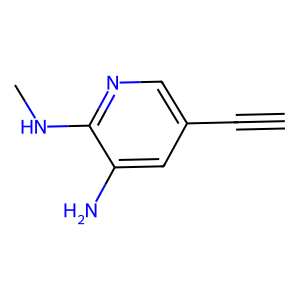

In [100]:
dataset[9968]

from rdkit import Chem
from rdkit.Chem import Draw

# SMILES string for the molecule
smiles = 'CNc1ncc(cc1N)C#C'

# Convert the SMILES string to a molecule
molecule = Chem.MolFromSmiles(smiles)

# Draw the molecule
Draw.MolToImage(molecule)


In [12]:
# if gnn == 'gin':
#     model = GNN(gnn_type = 'gin', virtual_node = False, **shared_params).to(device)
# elif gnn == 'gin-virtual':
#     print('virtual')
#     model = GNN(gnn_type = 'gin', virtual_node = True, **shared_params).to(device)
# elif gnn == 'gcn':
#     model = GNN(gnn_type = 'gcn', virtual_node = False, **shared_params).to(device)
# elif gnn == 'gcn-virtual':
#     model = GNN(gnn_type = 'gcn', virtual_node = True, **shared_params).to(device)
# else:
#     raise ValueError('Invalid GNN type')
model = GNN(gnn_type = 'gin', virtual_node = False, **shared_params).to(device)
num_params = sum(p.numel() for p in model.parameters())
print(f'#Params: {num_params}')

optimizer = optim.Adam(model.parameters(), lr=0.001)

if log_dir != '':
    writer = SummaryWriter(log_dir=log_dir)

best_valid_mae = 1000

if train_subset:
    scheduler = StepLR(optimizer, step_size=300, gamma=0.25)
    epochs = 1000
else:
    scheduler = StepLR(optimizer, step_size=30, gamma=0.25)

#Params: 3762006


In [13]:
for epoch in range(1, epochs + 1):
    print("=====Epoch {}".format(epoch))
    print('Training...')
    train_mae = train(model, device, train_loader, optimizer)

    print('Evaluating...')
    valid_mae = eval(model, device, valid_loader, evaluator)

    print({'Train': train_mae, 'Validation': valid_mae})

    if log_dir != '':
        writer.add_scalar('valid/mae', valid_mae, epoch)
        writer.add_scalar('train/mae', train_mae, epoch)

    if valid_mae < best_valid_mae:
        print('ok')
        best_valid_mae = valid_mae
        if checkpoint_dir != '':
            print('Saving checkpoint...')
            checkpoint = {'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'scheduler_state_dict': scheduler.state_dict(), 'best_val_mae': best_valid_mae, 'num_params': num_params}
            torch.save(checkpoint, os.path.join(checkpoint_dir, 'checkpoint.pt'))

        if save_test_dir != '':
            testdev_pred = test(model, device, testdev_loader)
            testdev_pred = testdev_pred.cpu().detach().numpy()

            testchallenge_pred = test(model, device, testchallenge_loader)
            testchallenge_pred = testchallenge_pred.cpu().detach().numpy()

            print('Saving test submission file...')
            evaluator.save_test_submission({'y_pred': testdev_pred}, save_test_dir, mode = 'test-dev')
            evaluator.save_test_submission({'y_pred': testchallenge_pred}, save_test_dir, mode = 'test-challenge')

    scheduler.step()
        
    print(f'Best validation MAE so far: {best_valid_mae}')

if log_dir != '':
    writer.close()

=====Epoch 1
Training...


Iteration:   0%|          | 0/13198 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/288 [00:00<?, ?it/s]

{'Train': 0.43347238924606657, 'Validation': 0.4017128050327301}
ok
Saving checkpoint...


Iteration:   0%|          | 0/575 [00:00<?, ?it/s]

Iteration:   0%|          | 0/576 [00:00<?, ?it/s]

Saving test submission file...
Best validation MAE so far: 0.4017128050327301
=====Epoch 2
Training...


Iteration:   0%|          | 0/13198 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/288 [00:00<?, ?it/s]

{'Train': 0.2556386063597133, 'Validation': 0.269629567861557}
ok
Saving checkpoint...


Iteration:   0%|          | 0/575 [00:00<?, ?it/s]

Iteration:   0%|          | 0/576 [00:00<?, ?it/s]

Saving test submission file...
Best validation MAE so far: 0.269629567861557
=====Epoch 3
Training...


Iteration:   0%|          | 0/13198 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/288 [00:00<?, ?it/s]

{'Train': 0.21519225103839054, 'Validation': 0.2649064064025879}
ok
Saving checkpoint...


Iteration:   0%|          | 0/575 [00:00<?, ?it/s]

Iteration:   0%|          | 0/576 [00:00<?, ?it/s]

Saving test submission file...
Best validation MAE so far: 0.2649064064025879
=====Epoch 4
Training...


Iteration:   0%|          | 0/13198 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/288 [00:00<?, ?it/s]

{'Train': 0.19315369099667623, 'Validation': 0.2182794064283371}
ok
Saving checkpoint...


Iteration:   0%|          | 0/575 [00:00<?, ?it/s]

Iteration:   0%|          | 0/576 [00:00<?, ?it/s]

Saving test submission file...
Best validation MAE so far: 0.2182794064283371
=====Epoch 5
Training...


Iteration:   0%|          | 0/13198 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/288 [00:00<?, ?it/s]

{'Train': 0.18006932201121661, 'Validation': 0.21624362468719482}
ok
Saving checkpoint...


Iteration:   0%|          | 0/575 [00:00<?, ?it/s]

Iteration:   0%|          | 0/576 [00:00<?, ?it/s]

Saving test submission file...
Best validation MAE so far: 0.21624362468719482
=====Epoch 6
Training...


Iteration:   0%|          | 0/13198 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/288 [00:00<?, ?it/s]

{'Train': 0.17106119917931747, 'Validation': 0.1893363744020462}
ok
Saving checkpoint...


Iteration:   0%|          | 0/575 [00:00<?, ?it/s]

Iteration:   0%|          | 0/576 [00:00<?, ?it/s]

Saving test submission file...
Best validation MAE so far: 0.1893363744020462
=====Epoch 7
Training...


Iteration:   0%|          | 0/13198 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/288 [00:00<?, ?it/s]

{'Train': 0.164261101049435, 'Validation': 0.1967756748199463}
Best validation MAE so far: 0.1893363744020462
=====Epoch 8
Training...


Iteration:   0%|          | 0/13198 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/288 [00:00<?, ?it/s]

{'Train': 0.15915891072220434, 'Validation': 0.17047260701656342}
ok
Saving checkpoint...


Iteration:   0%|          | 0/575 [00:00<?, ?it/s]

Iteration:   0%|          | 0/576 [00:00<?, ?it/s]

Saving test submission file...
Best validation MAE so far: 0.17047260701656342
=====Epoch 9
Training...


Iteration:   0%|          | 0/13198 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/288 [00:00<?, ?it/s]

{'Train': 0.15472673604092393, 'Validation': 0.170195534825325}
ok
Saving checkpoint...


Iteration:   0%|          | 0/575 [00:00<?, ?it/s]

Iteration:   0%|          | 0/576 [00:00<?, ?it/s]

Saving test submission file...
Best validation MAE so far: 0.170195534825325
=====Epoch 10
Training...


Iteration:   0%|          | 0/13198 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/288 [00:00<?, ?it/s]

{'Train': 0.15115151110856456, 'Validation': 0.16443860530853271}
ok
Saving checkpoint...


Iteration:   0%|          | 0/575 [00:00<?, ?it/s]

Iteration:   0%|          | 0/576 [00:00<?, ?it/s]

Saving test submission file...
Best validation MAE so far: 0.16443860530853271


NameError: name 'args' is not defined

In [14]:
if log_dir != '':
    writer.close()

In [51]:
ytest_act = valid_loader.dataset.y
ytest_pre = test(model, device, valid_loader)
# ytrain_act = train_graphs.dataset.y
# ytrain_pre = test(model, device, train_graphs)

Iteration:   0%|          | 0/288 [00:00<?, ?it/s]

In [75]:
model1 = GNN(gnn_type = 'gin', virtual_node = False, **shared_params).to(device)
checkpoint_path = r'D:\Studies\PHD\Research\Study\Study 4.2\property prediction\OGB\ogb\results\3\checkpoint.pt'  # Update with your checkpoint path
checkpointm = torch.load(checkpoint_path, map_location='cpu')  # Add map_location if using different device
model1.load_state_dict(checkpointm['model_state_dict'])

<All keys matched successfully>

In [78]:
ytest_act = valid_loader.dataset.y
ytest_pre = test(model1, device, valid_loader)

Iteration:   0%|          | 0/288 [00:00<?, ?it/s]

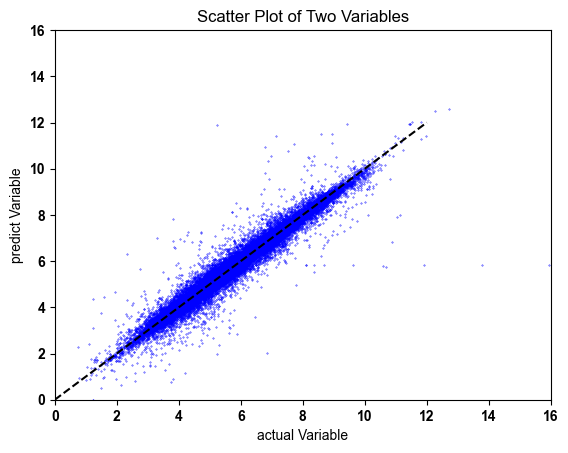

In [79]:
import matplotlib.pyplot as plt

# Create a scatter plot
#plt.scatter(y_act1, y_pre1, s=0.1, color='blue')
plt.scatter(ytest_act, ytest_pre, s=0.1, color='blue')
#plt.scatter(ytrain_act, ytrain_pre, s=0.1, color='red')


# Adding title and labels
plt.title("Scatter Plot of Two Variables")
plt.xlabel("actual Variable")
plt.ylabel("predict Variable")

plt.xlim(0, 16)
plt.ylim(0, 16)

plt.plot([0, 12], [0, 12], '--k', )#color='black')

plt.savefig("scatter_plot2.png")
# Show the plot
plt.show()

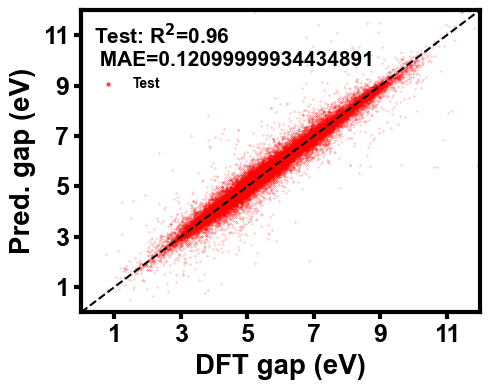

In [81]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error

mse_train = round(mean_squared_error(ytest_act, ytest_pre.reshape([-1])),3)
mae_train = round(mean_absolute_error(ytest_act, ytest_pre.reshape([-1])),3)

fig, ax = plt.subplots(figsize=(5, 4))
plt.rcParams["legend.markerscale"] = 10
plt.scatter (ytest_act, ytest_pre, color='red', label='Test', alpha=0.6, s=0.05)
# plt.scatter ( y_val0, pred0, color='blue', label='Test', alpha=0.6, s=0.05)

plt.legend()

ax.set_xlabel('DFT gap (eV)', fontsize='20', fontname='Arial', fontweight='bold', labelpad=5)
ax.set_ylabel('Pred. gap (eV)', fontsize='20', fontname='Arial', fontweight='bold', labelpad=5)

ax.tick_params(direction='out', length=5, width=3, colors='black', 
               grid_alpha=1, labelsize='18')

[i.set_linewidth(3) for i in ax.spines.values()]
# leg = plt.legend(title='Train: R$^2$={}, MAE={} \nTest: R$^2$={}, MAE={}'.\
#            format(round(r2_score(y_act, y_pre.reshape([-1])), 2), 
#                   mae_train,
#                   round (r2_score(y_act, y_pre.reshape([-1])), 2), 
#                   mae_train, 
#                 ), framealpha=0, title_fontsize=15)
# leg._legend_box.align = "left"

leg = plt.legend(title='Test: R$^2$={}\n MAE={}'.\
           format(round(r2_score(ytest_act, ytest_pre.reshape([-1])), 2), 
                  mae_train,
                  #round (r2_score(y_act, y_pre.reshape([-1])), 2), 
                  #mae_train, 
                ), framealpha=0, title_fontsize=15)
leg._legend_box.align = "left"

plt.xlim(0, 12)
plt.ylim(0, 12)
plt.xticks((1, 3, 5, 7, 9,  11));
plt.yticks((1, 3, 5, 7, 9,  11));
plt.plot([0, 12], [0, 12], '--k', )#color='black')
plt.tight_layout()
plt.savefig('regressor_train_test.jpeg', dpi=300)
plt.rcParams["legend.markerscale"] = 1

In [57]:
from sklearn.metrics import r2_score

# Assuming y_act1 and y_pre1 are already defined as mentioned
r_squared = r2_score(y_act, y_pre)
print("R-squared Score:", r_squared)


R-squared Score: 0.9320631734363946


In [54]:
round (mae_train, 2)

0.16